# Import Modules

In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.linear_model import LogisticRegression

In [2]:
from keras.layers import Dense,Dropout,LSTM

In [3]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from datetime import datetime
from scipy import stats
import random

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score,f1_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

# Load Data

In [ ]:
df = pd.read_csv('CRSP US Stock Returns.csv')
df_monthly = pd.read_csv('US stock return data - Monthly.csv')
df_WRDS = pd.read_csv('WRDS Financial Ratios.csv')

In [ ]:
df_WRDS['permno'] = df_WRDS['permno'].astype('int64')
df_monthly['PERMNO'] = df_monthly['PERMNO'].astype('int64')

In [ ]:
df_merged = pd.merge(df_monthly,df_WRDS,how='right',left_on=['PERMNO','date'],right_on=['permno','public_date'])
df_merged_ret = df_merged.dropna(subset=['RET'])

In [ ]:
df_merged_ret_num = df_merged_ret[df_merged_ret['RET']!='C']
df_merged_ret_num['RET'] = df_merged_ret_num['RET'].astype('float64')

In [ ]:
df_preprocessed = df_merged_ret_num.drop(
    columns=[
        "public_date",
        "DLRET",
        "adate",
        "qdate",
        "HSICIG",
        "SHRCD",
        "EXCHCD",
        "permno",
        "adv_sale",
        "aftret_eq",
        "aftret_equity",
        "capital_ratio",
        "cash_debt",
        "cash_lt",
        "cash_ratio",
        "cfm",
        "curr_debt",
        "debt_assets",
        "debt_at",
        "debt_capital",
        "debt_invcap",
        "dltt_be",
        "efftax",
        "equity_invcap",
        "fcf_ocf",
        "GProf",
        "int_debt",
        "intcov",
        "inv_turn",
        "invt_act",
        "lt_debt",
        "lt_ppent",
        "ocf_lct",
        "opmad",
        "opmbd",
        "pay_turn",
        "pcf",
        "pe_exi",
        "pe_inc",
        "pe_op_basic",
        "pe_op_dil",
        "PEG_trailing",
        "pretret_earnat",
        "pretret_noa",
        "profit_lct",
        "ptpm",
        "rect_act",
        "rect_turn",
        "roce",
        "sale_equity",
        "sale_invcap",
        "short_debt",
        "totdebt_invcap",
    ]
)

In [ ]:
def fix_divyield(divyield):
    '''
    input: Dividend yield, Object
    Output: Float version of the column
    Description: Remove string character % and convert to float
    '''
    if divyield == 'nan':
        return np.nan
    else:
        return float(str(divyield).replace('%',''))

In [ ]:
df_preprocessed['divyield'] = df_preprocessed.apply(lambda x: fix_divyield(x['divyield']),axis=1)

In [ ]:
df_preprocessed['RET_shifted'] = df_preprocessed['RET'].shift(-1)

In [ ]:
df_preprocessed = df_preprocessed.reset_index()
df_preprocessed = df_preprocessed.set_index('PERMNO')
df_preprocessed.sort_index(inplace=True)

df_preprocessed_copy = df_preprocessed.copy()

prev = 25881.0
for index,row in tqdm(df_preprocessed_copy.iterrows(),total=df_preprocessed_copy.shape[0]):
    if prev == index:
        pass
    else:
        prev = index
        df_preprocessed.loc[(df_preprocessed['date']==row['date'])&(df_preprocessed.index==index),'RET_shifted'] = np.nan

In [ ]:
df_preprocessed = df_preprocessed.reset_index()
df_preprocessed = df_preprocessed.set_index(['date','PERMNO'])
df_preprocessed.sort_index(inplace=True)
df_preprocessed = df_preprocessed.dropna(subset=['RET_shifted'])

In [ ]:
df_preprocessed.to_csv('df_preprocessed.csv')

## Load preprocessed data directly

In [7]:
df_preprocessed = pd.read_csv('df_preprocessed.csv')
df_preprocessed = df_preprocessed.set_index('PERMNO').sort_index()

In [8]:
df_preprocessed['mom1m'] = np.log(df_preprocessed['PRC']/df_preprocessed['PRC'].shift(1))

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
df_preprocessed = df_preprocessed.reset_index()
df_preprocessed = df_preprocessed.set_index(['date','PERMNO'])

In [10]:
df_preprocessed.sort_index(inplace=True)

In [12]:
def normalize_features(group):
    '''
    Input:
    Output:
    Description: Normalise Values 
    '''
    group[features] = ((group[features] - group[features].mean()) / group[features].std()).values

    return group

In [18]:
features = df_preprocessed.columns.tolist()

In [20]:
features.remove('RET_shifted')

In [21]:
df = df_preprocessed.groupby(level=0).apply(normalize_features)
df['label'] = df.apply(lambda x: 0 if x['RET_shifted']<0 else 1,axis=1)

In [310]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

In [312]:
missing_value_df.nlargest(5,columns='percent_missing')

,percent_missing
divyield,61.328934
sale_nwc,27.311480
dpr,27.110888
cash_conversion,26.592157
int_totdebt,24.830309


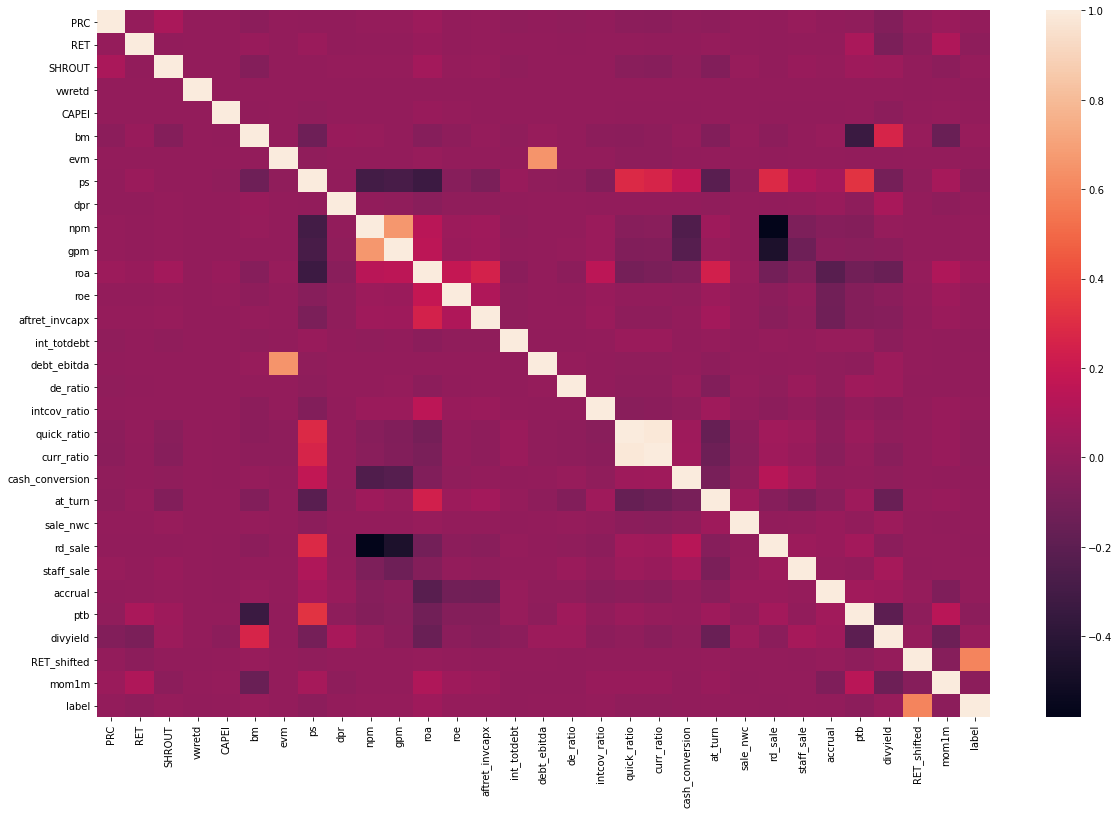

In [290]:
fig, ax = plt.subplots(figsize=(20,13))
sns.heatmap(df.corr(),annot=False,ax=ax,fmt=".1")

# Split Data

In [23]:
training_set = df.loc[:'2012-12-31']
testing_set = df.loc['2012-12-31':]
X, y = training_set[features], training_set['RET_shifted']
X_test, y_test = testing_set[features], testing_set['RET_shifted']

# Missing Data Imputation

In [24]:
for column in X.columns.tolist():
    if X[column].isna().sum() != 0:
        X[column].fillna(np.mean(X[column]),inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [25]:
for column in X_test.columns.tolist():
    if X_test[column].isna().sum() != 0:
        X_test[column].fillna(np.mean(X_test[column]),inplace=True)

# Regression for t+1

## Linear Regression

In [45]:
X_lr = X.copy()
y_lr = y.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

In [46]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [47]:
results = sm.OLS(y_lr.values, X_lr.values).fit()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              159.3
Date:                Wed, 24 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:47:01   Log-Likelihood:                      4.1542e+05
No. Observations:             1547241   AIC:                                 -8.308e+05
Df Residuals:                 1547212   BIC:                                 -8.304e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.000      2.054      0.040     1.4e-05       0.001
x2            -0.0037      0.000    -24.889      0.000      -0.004      -0.003
x3            -0.0009      0.000     -6.139      0.000      -0.001      -0.001
x4             0.0002      0.000      1.191      0.234      -0.000       0.000
x5          2.848e-05      0.000      0.178      0.859      -0.000       0.000
x6             0.0019      0.000     11.571      0.000       0.002       0.002
x7             0.0004      0.000      1.940      0.052   -3.99e-06       0.001
x8             0.0004      0.000      1.939      0.052   -3.86e-06       0.001
x9            -0.0002      0.000     -1.039      0.299      -0.001       0.000
x10            0.0002      0.000      0.943      0.346      -0.000       0.001
x11           -0.0003      0.000     -1.638      0.101      -0.001    6.35e-05
x12            0.0028      0.000     16.104      0.000       0.002       0.003
x13         9.876e-05      0.000      0.631      0.528      -0.000       0.000
x14           -0.0004      0.000     -2.695      0.007      -0.001      -0.000
x15            0.0007      0.000      3.964      0.000       0.000       0.001
x16           -0.0004      0.000     -1.814      0.070      -0.001    2.96e-05
x17           -0.0001      0.000     -0.865      0.387      -0.000       0.000
x18           -0.0002      0.000     -1.181      0.238      -0.001       0.000
x19            0.0035      0.001      3.649      0.000       0.002       0.005
x20           -0.0027      0.001     -2.841      0.004      -0.005      -0.001
x21         3.423e-05      0.000      0.191      0.848      -0.000       0.000
x22            0.0017      0.000     10.409      0.000       0.001       0.002
x23           -0.0001      0.000     -0.805      0.421      -0.000       0.000
x24            0.0004      0.000      1.969      0.049    1.64e-06       0.001
x25           -0.0002      0.000     -1.194      0.233      -0.000       0.000
x26            0.0017      0.000     10.740      0.000       0.001       0.002
x27           -0.0010      0.000     -5.694      0.000      -0.001      -0.001
x28            0.0001      0.000      0.441      0.659      -0.000       0.001
x29           -0.0086      0.000    -51.704      0.000      -0.009      -0.008
==============================================================================
Omnibus:                  1812919.568   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2020129830.283
Skew:                           5.364   Prob(JB):                         0.00
Kurtosis:                     179.692   Cond. No.                         14.5
=============================================================

In [51]:
reg = LinearRegression().fit(X_lr, y_lr)
y_pred_lr = reg.predict(X_test_lr)

### Metrics - Linear Regression

In [64]:
print('The R2 score is:',r2_score(y_test_lr,y_pred_lr))
print('The RMSE error is:',np.sqrt(mean_squared_error(y_test_lr,y_pred_lr)))
print('The MAE is:',mean_absolute_error(y_test_lr,y_pred_lr))

The R2 score is: 0.0009462732278250341
The RMSE error is: 0.1820071279017174
The MAE is: 0.10208056779376116


In [73]:
print('R2',reg.score(X_test_lr,y_test_lr))

R2 0.0009462732278250341


## Light GBM

In [67]:
X_gbm = X.copy()
y_gbm = y.copy()
X_test_gbm = X_test.copy()
y_test_gbm = y_test.copy()

In [359]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2'], #why auc?
    'learning_rate': 0.001,
    'verbose': 2,
    "max_depth": 13,
 #   "num_leaves": 25,  
    "max_bin": 64,
    "num_iterations": 300,
    "n_estimators": 100
}

In [360]:
def train_predict_lgbm_regression(hyper_params,X_train,y_train,X_test):
    '''
    input: Hyperparameters & training data for lightgbm
    output: model & predictions
    Description: Train a light GBM model and calculate the predictions
    '''
    gbm = lgb.LGBMRegressor(**hyper_params)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

    return gbm,y_pred

In [361]:
gbm,y_pred = train_predict_lgbm_regression(hyper_params,X_gbm,y_gbm,X_test_gbm)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000113 seconds, init for row-wise cost 0.135315 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 1547241, number of used features: 29
[LightGBM] [Info] Start training from score 0.013463
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[LightGBM] [Debug] Trained a tree with

### Metrics

In [362]:
print('The R2 score is:',r2_score(y_test_gbm,y_pred))
print('The RMSE error is:',np.sqrt(mean_squared_error(y_test_gbm,y_pred)))
print('The MAE is:',mean_absolute_error(y_test_gbm,y_pred))

The R2 score is: 0.0006158315948036064
The RMSE error is: 0.18203722526217686
The MAE is: 0.10176497347732447


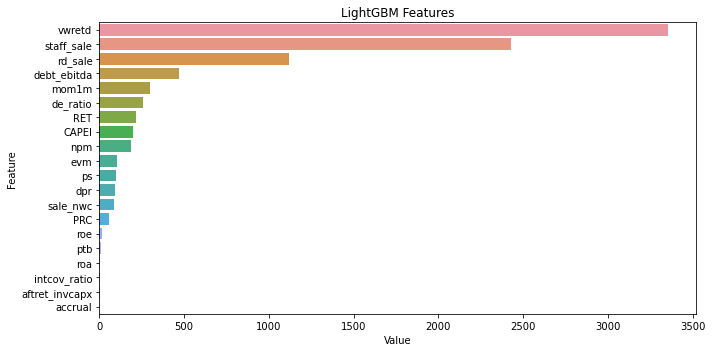

In [363]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_gbm.columns)), columns=['Value','Feature'])
data=feature_imp.sort_values(by="Value", ascending=False)
data=data.head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=data)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## LSTM

In [77]:
X_lstm = X.copy()
y_lstm = y.copy()
X_test_lstm = X_test.copy()
y_test_lstm = y_test.copy()

In [78]:
def preprocess_nn_regression(X_train,y_train,X_test):
    '''
    input: Train & test data
    output: Keras-ready data
    Description: Preprocess data for the neural network regression
    '''
    X_train_keras = X_train.copy()
    y_train_keras = y_train.copy()
    X_test_keras = X_test.copy()
    y_test_keras = y_test.copy()
    X_train_keras = X_train_keras.values.reshape(X_train_keras.shape[0], X_train_keras.shape[1], 1)
    X_test_keras = X_test_keras.values.reshape(X_test_keras.shape[0],X_test_keras.shape[1],1)
    y_train = y_train.values.reshape(y_train.shape[0],1)
    return X_train_keras,X_test_keras,y_train_keras

In [79]:
X_tr_keras,X_test_keras,y_tr_keras = preprocess_nn_regression(X_lstm,y_lstm,X_test_lstm)

In [84]:
def create_model(units, m,X_train):
    '''
    input: type of layer, Number of units, train data
    output: compiled model
    Description: Design architecture of the neural network model
    '''
    model = Sequential()
    model.add(m (units = units, kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1), bias_regularizer=l2(0.1),return_sequences = True,
                input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(m (units = units, kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [85]:
model_lstm = create_model(64, LSTM,X_tr_keras)

In [86]:
def fit_model(model,X_train,y_train):
    '''
    input: Model, training data
    Output: fitted model
    Description: Perform model fitting
    '''
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 2,  
                        validation_split = 0.2, batch_size = 128, 
                        shuffle = False, callbacks = [early_stop])
    return history#

history_lstm = fit_model(model_lstm,X_tr_keras,y_tr_keras)

Epoch 1/2
9671/9671 [==============================] - 746s 77ms/step - loss: 0.6618 - val_loss: 0.0332
Epoch 2/2
9671/9671 [==============================] - 746s 77ms/step - loss: 0.0340 - val_loss: 0.0330


In [87]:
y_pred_lstm = model_lstm.predict(X_test_keras)

### Metrics

In [88]:
print('The R2 score is:',r2_score(y_test_lstm,y_pred_lstm))
print('The RMSE error is:',np.sqrt(mean_squared_error(y_test_lstm,y_pred_lstm)))
print('The MAE is:',mean_absolute_error(y_test_lstm,y_pred_lstm))

The R2 score is: -0.04767028183419186
The RMSE error is: 0.18638299529495395
The MAE is: 0.1111951094263056


# Classification for trend Analysis

In [410]:
features = df_preprocessed.columns.tolist()
features.remove('RET_shifted')

In [411]:
training_set_cf = df.loc[:'2012-12-31']
testing_set_cf = df.loc['2012-12-31':]
X_cf, y_cf = training_set[features], training_set['label']
X_test_cf, y_test_cf = testing_set[features], testing_set['label']

In [412]:
for column in X_cf.columns.tolist():
    if X_cf[column].isna().sum() != 0:
        X_cf[column].fillna(np.mean(X_cf[column]),inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [413]:
for column in X_test_cf.columns.tolist():
    if X_test_cf[column].isna().sum() != 0:
        X_test_cf[column].fillna(np.mean(X_test_cf[column]),inplace=True)

## Logistic Regression

In [414]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_cf, y_cf)
y_pred_log_cf = model.predict(X_test_cf)

### Metrics

In [415]:
print('f1 score of logistic regression classification:',f1_score(y_test_cf,y_pred_log_cf))
print('recall of logistic regression classification:',recall_score(y_test_cf,y_pred_log_cf))
print('precision of logistic regression classification:',precision_score(y_test_cf,y_pred_log_cf))
print('accuracy of logistic regression classification:',accuracy_score(y_test_cf,y_pred_log_cf))

f1 score of logistic regression classification: 0.6787398024023285
recall of logistic regression classification: 0.9302580382351702
precision of logistic regression classification: 0.5342831557122457
accuracy of logistic regression classification: 0.5354169368434704


## LightGBM

In [416]:
def train_lightGBM(X_train,X_test,y_train,y_test,params,num_boost_rounds_lgb):
    '''
    input: Train, test data
    output: model lgbm
    Description: train & predict lightgbm
    '''
    dtrain_lgb = lgb.Dataset(X_train.values, label=y_train)
    model_lgb = lgb.train(params, dtrain_lgb, num_boost_round=num_boost_rounds_lgb)
    y_pred_lgbm = model_lgb.predict(X_test)
    
    return model_lgb,y_pred_lgbm

In [436]:
params_lgb = {}
params_lgb['max_bin'] = 800
params_lgb['learning_rate'] = 0.01
params_lgb['num_leaves']=128
params_lgb['max_depth'] = 30
params_lgb['verbose'] = 1

In [437]:
model_lgb_clf,y_pred_lgbm_clf = train_lightGBM(X_cf,X_test_cf,y_cf,y_test_cf,params_lgb,500)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22743
[LightGBM] [Info] Number of data points in the train set: 1547241, number of used features: 29
[LightGBM] [Info] Start training from score 0.531372


### Metrics

In [438]:
y_pred_lgbm_clf=y_pred_lgbm_clf.round(0)
y_pred_lgbm_clf=y_pred_lgbm_clf.astype(int)
print('f1 score of lightGBM classification:',f1_score(y_test_cf,y_pred_lgbm_clf))
print('recall of lightGBM classification:',recall_score(y_test_cf,y_pred_lgbm_clf))
print('precision of lightgBM classification:',precision_score(y_test_cf,y_pred_lgbm_clf))
print('accuracy of lightGBM classification:',accuracy_score(y_test_cf,y_pred_lgbm_clf))

f1 score of lightGBM classification: 0.6380607364220418
recall of lightGBM classification: 0.7916941748254696
precision of lightgBM classification: 0.5343639190701026
accuracy of lightGBM classification: 0.5261537321451729


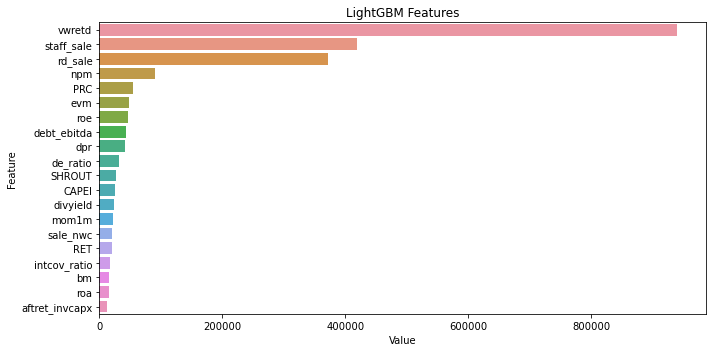

In [439]:
feature_imp = pd.DataFrame(sorted(zip(model_lgb_clf.feature_importance(importance_type='gain'),X.columns)), columns=['Value','Feature'])
data=feature_imp.sort_values(by="Value", ascending=False)
data=data.head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=data)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## Portfolio Creation - LightGBM

In [440]:
y_test_hat = model_lgb_clf.predict(X_test_cf)
y_test_hat = pd.DataFrame(y_test_hat, columns=['score'], index=X_test_cf.index)
y_test_hat.insert(1,'y', y_test_cf.values)
y_test_hat['RET_shifted'] = testing_set['RET_shifted']

In [441]:
test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))

#### long portfolio

In [442]:
test_long_portfolio = test_long_portfolio.reset_index(level=1, drop=True)
test_long_portfolio = test_long_portfolio.reset_index()
test_long_portfolio = test_long_portfolio.set_index(['date', 'PERMNO'])

In [443]:
monthly_return = test_long_portfolio.groupby(level=0).mean()
monthly_return = pd.DataFrame(monthly_return['RET_shifted'])
monthly_return = monthly_return.reset_index()
monthly_return['RET_shifted'] = monthly_return['RET_shifted'].shift()
monthly_return.columns = ['date', 'return']
monthly_return['cum_return'] = (monthly_return['return']+1).cumprod()-1

In [444]:
sr = (monthly_return['return'].mean() / monthly_return['return'].std()) * np.sqrt(12)
sr

0.8072258458067917

#### Short portfolio

In [445]:
test_short_portfolio = test_short_portfolio.reset_index(level=1, drop=True)
test_short_portfolio = test_short_portfolio.reset_index()
test_short_portfolio = test_short_portfolio.set_index(['date', 'PERMNO'])

In [446]:
short_monthly_return = test_short_portfolio.groupby(level=0).mean()
short_monthly_return = pd.DataFrame(short_monthly_return['RET_shifted'])
short_monthly_return = short_monthly_return.reset_index()
short_monthly_return['RET_shifted'] = short_monthly_return['RET_shifted'].shift() # shift return to the actual realized date
short_monthly_return = short_monthly_return.dropna()
short_monthly_return.columns = ['date', 'return']
short_monthly_return['cum_return_orig'] = (short_monthly_return['return']+1).cumprod()-1

In [447]:
short_monthly_return

,date,return,cum_return_orig
1,2012/02/29,0.053856,0.053856
2,2012/04/30,-0.051189,-0.000090
3,2012/05/31,-0.126537,-0.126616
4,2012/07/31,-0.000385,-0.126952
5,2012/08/31,-0.016667,-0.141504
...,...,...,...
72,2020/07/31,0.032698,-0.753054
73,2020/08/31,-0.045975,-0.764407
74,2020/09/30,-0.040656,-0.773986
75,2020/11/30,0.242734,-0.719124


In [448]:
short_monthly_return['return'] = -short_monthly_return['return']

In [449]:
short_monthly_return['cum_return'] = (short_monthly_return['return']+1).cumprod()-1
short_monthly_return

,date,return,cum_return_orig,cum_return
1,2012/02/29,-0.053856,0.053856,-0.053856
2,2012/04/30,0.051189,-0.000090,-0.005424
3,2012/05/31,0.126537,-0.126616,0.120427
4,2012/07/31,0.000385,-0.126952,0.120859
5,2012/08/31,0.016667,-0.141504,0.139540
...,...,...,...,...
72,2020/07/31,-0.032698,-0.753054,1.411679
73,2020/08/31,0.045975,-0.764407,1.522557
74,2020/09/30,0.040656,-0.773986,1.625114
75,2020/11/30,-0.242734,-0.719124,0.987909


In [450]:
sr = (short_monthly_return['return'].mean() / short_monthly_return['return'].std()) * np.sqrt(12)
sr

0.44580899162553467

#### Long-short portfolio

In [451]:
monthly_return_dates = monthly_return['date'].tolist()
monthly_short_dates = short_monthly_return['date'].tolist()
date = [x for x in monthly_return_dates if x not in monthly_short_dates]
monthly_return = monthly_return[~monthly_return['date'].isin(date)]

In [452]:
portfolio_1 = short_monthly_return['return'] + monthly_return['return']
portfolio_1 = pd.DataFrame(portfolio_1.values, index = short_monthly_return['date'], columns=['return'])
portfolio_2 = (-short_monthly_return['return'] + monthly_return['return'])/2
portfolio_2 = pd.DataFrame(portfolio_2.values, index = short_monthly_return['date'], columns=['return'])

In [453]:
sr_1 = (portfolio_1['return'].mean() / portfolio_1['return'].std()) * np.sqrt(12)
sr_1

1.2958010167692056

In [454]:
sr_2 = (portfolio_2['return'].mean() / portfolio_2['return'].std()) * np.sqrt(12)
sr_2

0.0509308766929558

## Portfolio Creation - Logistic Regression

In [152]:
y_test_hat_log = model.predict(X_test_cf)
y_test_hat_log = pd.DataFrame(y_test_cf, columns=['score'], index=X_test_cf.index)
y_test_hat_log.insert(1,'y', y_test_cf.values)
y_test_hat_log['RET_shifted'] = testing_set['RET_shifted']

In [153]:
test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))

#### long portfolio

In [154]:
test_long_portfolio = test_long_portfolio.reset_index(level=1, drop=True)
test_long_portfolio = test_long_portfolio.reset_index()
test_long_portfolio = test_long_portfolio.set_index(['date', 'PERMNO'])

In [155]:
monthly_return = test_long_portfolio.groupby(level=0).mean()
monthly_return = pd.DataFrame(monthly_return['RET_shifted'])
monthly_return = monthly_return.reset_index()
monthly_return['RET_shifted'] = monthly_return['RET_shifted'].shift()
monthly_return.columns = ['date', 'return']
monthly_return['cum_return'] = (monthly_return['return']+1).cumprod()-1

In [156]:
sr = (monthly_return['return'].mean() / monthly_return['return'].std()) * np.sqrt(12)
sr

0.8072258458067917

#### Short portfolio

In [158]:
test_short_portfolio = test_short_portfolio.reset_index(level=1, drop=True)
test_short_portfolio = test_short_portfolio.reset_index()
test_short_portfolio = test_short_portfolio.set_index(['date', 'PERMNO'])

In [159]:
short_monthly_return = test_short_portfolio.groupby(level=0).mean()
short_monthly_return = pd.DataFrame(short_monthly_return['RET_shifted'])
short_monthly_return = short_monthly_return.reset_index()
short_monthly_return['RET_shifted'] = short_monthly_return['RET_shifted'].shift() # shift return to the actual realized date
short_monthly_return = short_monthly_return.dropna()
short_monthly_return.columns = ['date', 'return']
short_monthly_return['cum_return_orig'] = (short_monthly_return['return']+1).cumprod()-1
short_monthly_return['return'] = -short_monthly_return['return']

In [160]:
sr = (short_monthly_return['return'].mean() / short_monthly_return['return'].std()) * np.sqrt(12)
sr

0.44580899162553467

In [455]:
portfolio_1['cum_return'] = (portfolio_1['return']+1).cumprod()-1

## Plots for cumulative returns

In [456]:
x_labels = []
xlab = []
count = 0
month = ['dummy','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in portfolio_2.index.tolist():
    if count%10==0:
        x_labels.append(i)
        xlab.append(month[int(i[5:7])]+ ' ' +i[:4])
    count+=1

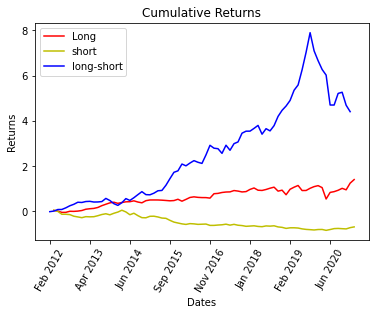

In [457]:
plt.plot(monthly_return['cum_return'],label='Long',color='r')
plt.plot(short_monthly_return['cum_return_orig'],label='short',color='y')
plt.plot(portfolio_1['cum_return'],label='long-short',color='b')
plt.xticks(x_labels,xlab,rotation=60)
plt.xlabel('Dates')
plt.ylabel('Returns')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

# Regression for Return at t

In [122]:
features = df_preprocessed.columns[4:-3].tolist()

In [124]:
training_set = df.loc[:'2012-12-31']
testing_set = df.loc['2012-12-31':]
X_t, y_t = training_set[features], training_set['RET']
X_test_t, y_test_t = testing_set[features], testing_set['RET']

In [139]:
for column in X_t.columns.tolist():
    if X_t[column].isna().sum() != 0:
        X_t[column].fillna(np.mean(X_t[column]),inplace=True)
        
for column in X_test_t.columns.tolist():
    if X_test_t[column].isna().sum() != 0:
        X_test_t[column].fillna(np.mean(X_test_t[column]),inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## LightGBM

In [140]:
gbm_t,y_pred_t = train_predict_lgbm_regression(hyper_params,X_t,y_t,X_test_t)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000073 seconds, init for row-wise cost 0.136826 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11776
[LightGBM] [Info] Number of data points in the train set: 1547241, number of used features: 23
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 128 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 

### Metrics

In [141]:
print('The R2 score is:',r2_score(y_test_t.values,y_pred_t))
print('The RMSE error is:',np.sqrt(mean_squared_error(y_test_t.values,y_pred_t)))
print('The MAE is:',mean_absolute_error(y_test_t.values,y_pred_t))

The R2 score is: 0.021454115328272794
The RMSE error is: 0.9890736569992988
The MAE is: 0.5799627657024549


## Linear Regression

In [142]:
reg_t = LinearRegression()
reg_t.fit(X_t,y_t)
y_pred_lr_t = reg_t.predict(X_test_t)

### Metrics

In [143]:
print('The R2 score is:',r2_score(y_test_t.values,y_pred_lr_t))
print('The RMSE error is:',np.sqrt(mean_squared_error(y_test_t.values,y_pred_lr_t)))
print('The MAE is:',mean_absolute_error(y_test_t.values,y_pred_lr_t))

The R2 score is: 0.004429984368072515
The RMSE error is: 0.9976402020926493
The MAE is: 0.5852131725932167
